In [63]:
# Import stuff
from torchvision import transforms, datasets
import os
from PIL import Image
import numpy as np
import platform
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import DataLoader, random_split
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [27]:
# Delete images in 128x128_data if needed
normal_dir = "128x128_data/NORMAL"
pneumonia_dir = "128x128_data/PNEUMONIA"

for file in os.listdir(normal_dir) + os.listdir(pneumonia_dir):
    img_path = os.path.join(normal_dir if file in os.listdir(normal_dir) else pneumonia_dir, file)
    os.remove(img_path)

In [64]:
# Select device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device.type}\n")

Using device: mps



# Data Preparation

#### Resize the images to 128 x 128

In [29]:
# Set up paths
normal_dir = "data/NORMAL"
pneumonia_dir = "data/PNEUMONIA"

# Find which images have the smallest size
min_size = float('inf')
min_dimensions = (float('inf'), float('inf'))
smallest_img_path = ""

for image in os.listdir(normal_dir) + os.listdir(pneumonia_dir):
    if image.endswith((".jpeg", ".jpg", ".png")):
        img_path = os.path.join(normal_dir if image in os.listdir(normal_dir) else pneumonia_dir, image)
        with Image.open(img_path, "r") as img:
            width, height = img.size
            if width * height < min_size:
                min_size = width * height
                min_dimensions = (width, height)
                smallest_img_path = img_path

print(f"Smallest image dimensions: {min_dimensions}")
print(f"Smallest image path: {smallest_img_path}")

# Paths for resized images
resized_normal_dir = "128x128_data/NORMAL"
resized_pneumonia_dir = "128x128_data/PNEUMONIA"

# Resize all images to 128x128 pixels and save them
for image in os.listdir(normal_dir) + os.listdir(pneumonia_dir):
    if image.endswith((".jpeg", ".jpg", ".png")):
        img_path = os.path.join(normal_dir if image in os.listdir(normal_dir) else pneumonia_dir, image)
        with Image.open(img_path, "r") as img:
            img = img.convert("L")  # Convert to grayscale
            width, height = img.size
            if width > height:
                cropped_width = 128
                cropped_height = int(height * 128 / width)
            else:
                cropped_height = 128
                cropped_width = int(width * 128 / height)
            img = img.resize((cropped_width, cropped_height)) # Resize preserving ratio
            left = 0
            upper = (cropped_height - 128) // 2
            right = 128
            lower = upper + 128
            img = img.crop((left, upper, right, lower)) # Center crop

            if "NORMAL" in img_path:
                save_path = os.path.join(resized_normal_dir, image)
            else:
                save_path = os.path.join(resized_pneumonia_dir, image)
            img.save(save_path)

# ~30 seconds

Smallest image dimensions: (384, 127)
Smallest image path: data/PNEUMONIA/person407_virus_811.jpeg


#### Augment the normal images to fix imbalance

In [30]:
# Count the images
normal_count = len([file for file in os.listdir(resized_normal_dir) if file.endswith(('.jpeg', '.jpg', '.png'))])
pneumonia_count = len([file for file in os.listdir(resized_pneumonia_dir) if file.endswith(('.jpeg', '.jpg', '.png'))])
print(f"Normal count: {normal_count}")
print(f"Pneumonia count: {pneumonia_count}")

# Augmentations
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1)
])

print("\nRunning augmentations")
while normal_count < pneumonia_count:
    for image in os.listdir(resized_normal_dir):
        img_path = os.path.join(resized_normal_dir, image)
        with Image.open(img_path, "r") as img:
            augmented_img = augmentations(img)
            name = f"{img_path.split('.')[0]}_augmented.{img_path.split('.')[-1]}"
            augmented_img.save(os.path.join(name))
            normal_count = len([file for file in os.listdir(resized_normal_dir) if file.endswith(('.jpeg', '.jpg', '.png'))])
            print(f"normal_count: {normal_count}", end='\r')
            if normal_count >= pneumonia_count:
                break

print("\n\nAugmentation done")
normal_count = len([file for file in os.listdir(resized_normal_dir) if file.endswith(('.jpeg', '.jpg', '.png'))])
pneumonia_count = len([file for file in os.listdir(resized_pneumonia_dir) if file.endswith(('.jpeg', '.jpg', '.png'))])
print(f"normal_count: {normal_count}")
print(f"pneumonia_count: {pneumonia_count}")

# ~6s

Normal count: 1583
Pneumonia count: 4273

Running augmentations
normal_count: 4273

Augmentation done
normal_count: 4273
pneumonia_count: 4273


#### Ensure that all of the images are the same shape

In [31]:
# Convert each image to a tensor and ensure they are all 1 x 128 x 128
counter = 0
for image in os.listdir(resized_normal_dir) + os.listdir(resized_pneumonia_dir):
    if image.endswith((".jpeg", ".jpg", ".png")):
        img_path = os.path.join(resized_normal_dir if image in os.listdir(resized_normal_dir) else resized_pneumonia_dir, image)
        with Image.open(img_path, "r") as img:
            img_tensor = transforms.ToTensor()(img)
            if img_tensor.shape != (1, 128, 128):
                print(f"{image} has shape {img_tensor.shape}")
                counter += 1
print(f"{counter} images with incorrect shape")

# ~14s

0 images with incorrect shape


#### Load the data

In [65]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# NORMAL = 0, PNEUMONIA = 1
dataset = datasets.ImageFolder(
    root="128x128_data",
    transform=transform
)

print(f"Classes: {dataset.classes}")

# Split data
train_size = int(0.8 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = len(dataset) - train_size - test_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

# DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Batch size: {batch_size}")

Classes: ['NORMAL', 'PNEUMONIA']
Train size: 6836
Val size: 856
Test size: 854
Batch size: 128


# Fully Connected Neural Network

#### Model

In [66]:
# Define the network
class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )
    def forward(self, x):
        return self.net(x)


#### Parameters

In [67]:
# Define the training parameters
model = MLP(128*128).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
epochs = 100
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

# Calculate accuracy from logits
def accuracy_from_logits(logits, y):
    preds = logits.argmax(1)  # choose class with highest predicted score
    return (preds == y).float().mean().item()  # fraction of correct predictions


#### Training

In [68]:
def train(name):
    # Early stopping settings
    patience = 10          # epochs to wait after last improvement
    min_delta = 0.0        # minimum change in val_loss to qualify as improvement
    best_val = 10e20       # track best validation loss
    best_epoch = -1
    patience_ctr = 0
    best_ckpt_path = "best.pt"

    train_start_time = time.time()

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()

        # Training
        model.train()
        running_loss, running_correct, total = 0.0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            running_correct += (logits.argmax(1) == y).sum().item()
            total += x.size(0)

        train_loss = running_loss / total
        train_acc  = running_correct / total

        # Validation
        model.eval()
        val_running_loss, val_running_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits, y)
                val_running_loss += loss.item() * x.size(0)
                val_running_correct += (logits.argmax(1) == y).sum().item()
                val_total += x.size(0)

        val_loss = val_running_loss / val_total
        val_acc  = val_running_correct / val_total

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch:02d} | "
            f"train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
            f"val: loss={val_loss:.4f}, acc={val_acc:.4f} | "
            f"time: {epoch_time:.2f}s")

        # Early stopping check (monitor val_loss)
        if val_loss < best_val - min_delta:
            best_val = val_loss
            best_epoch = epoch
            patience_ctr = 0
            # Save best checkpoint so far
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "history": history,
                "best_val_loss": best_val
            }, best_ckpt_path)
            print(f"  -> New best val_loss {best_val:.4f} at epoch {epoch}. Saved to {best_ckpt_path}.")
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                print(f"\nEarly stopping triggered at epoch {epoch} "
                    f"(no improvement for {patience} epochs). Best epoch: {best_epoch}.")
                break

    # Total training time
    total_time = time.time() - train_start_time
    print(f"\nTotal training time: {total_time:.2f}s")
    print(f"Best epoch: {best_epoch} | Best val_loss: {best_val:.4f}")

    # Restore best model before final save (in case we stopped after it)
    ckpt = torch.load(best_ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])

    # Save final artifact (model + history)
    final_path = f"models/{name}.pth"
    torch.save({
        "model_state": model.state_dict(),
        "history": history,
        "best_epoch": best_epoch,
        "best_val_loss": best_val
    }, final_path)
    print(f"Final model saved to '{final_path}'")

# 5:41 on MPS (batch size = 64)
# 3:34 on MPS (batch size = 128)
# 2:45 on MPS (batch size = 256)
# 7:50 on CPU
# 6:20 on L4

# With augmentations:
# 5:03 on MPS (batch size = 128)

# With early stopping:
# 1:12 on MPS (batch size = 128)

#### Results

In [69]:
def display_results(path):
    # Loss and accuracy graph
    # Load the trained model from file
    model = MLP(128*128).to(device)  # initialize model structure
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    history = checkpoint["history"]

    model.eval()  # set to evaluation mode

    # Prepare x-axis for plots
    epochs = range(1, len(history["train_loss"]) + 1)

    # Create figure and first axis (loss)
    fig, ax1 = plt.subplots()

    color_loss = "tab:blue"
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color=color_loss)
    ax1.plot(epochs, history["train_loss"], label="Train Loss", color=color_loss, linestyle="-")
    ax1.plot(epochs, history["val_loss"], label="Val Loss", color=color_loss, linestyle="--")
    ax1.tick_params(axis="y", labelcolor=color_loss)

    # Second y-axis for accuracy
    ax2 = ax1.twinx()
    color_acc = "tab:orange"
    ax2.set_ylabel("Accuracy", color=color_acc)
    ax2.plot(epochs, history["train_acc"], label="Train Acc", color=color_acc, linestyle="-")
    ax2.plot(epochs, history["val_acc"], label="Val Acc", color=color_acc, linestyle="--")
    ax2.tick_params(axis="y", labelcolor=color_acc)

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right")

    plt.title("Loss and Accuracy over Epochs")
    fig.tight_layout()
    plt.show()




    # Confusion matrix
    # Variables to track accuracy
    test_correct, test_total = 0, 0

    # Lists to store predictions and true labels for the confusion matrix
    all_preds, all_trues = [], []

    # Disable gradient computation for faster evaluation
    with torch.no_grad():
        # Loop through the test set in batches
        for x, y in test_loader:
            # Move inputs to the computation device (CPU/GPU/MPS)
            x = x.to(device)
            
            # Forward pass to get raw model outputs (logits)
            logits = model(x)
            
            # Get predicted class indices (highest logit per sample)
            preds = logits.argmax(1).cpu().numpy()
            
            # Store predictions and ground truth labels for later
            all_preds.append(preds)
            all_trues.append(y.numpy())
            
            # Update accuracy counters
            test_correct += (preds == y.numpy()).sum()
            test_total   += y.size(0)

    # Compute overall test accuracy
    test_acc = test_correct / test_total
    print(f"Test accuracy: {test_acc:.4f}")

    # Flatten predictions and true labels into 1D arrays
    y_true = np.concatenate(all_trues).ravel()
    y_pred = np.concatenate(all_preds).ravel()

    # Dynamically detect classes from both true and predicted
    class_labels = np.unique(np.concatenate((y_true, y_pred)))
    print(f"Detected {len(class_labels)} classes: {class_labels}")

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)

    # Plot annotated confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(
        cm,
        annot=True,              # annotate all cells
        fmt="d",                 # integer format
        cbar=True,
        xticklabels=class_labels,
        yticklabels=class_labels
    )
    plt.title("Confusion Matrix (Test)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

#### Baseline Performance (no augmentations)

In [11]:
train("baseline")

Epoch 01 | train: loss=37857.8234, acc=0.7032 | val: loss=524.2303, acc=0.8433 | time: 2.82s
  -> New best val_loss 524.2303 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=269.6680, acc=0.7607 | val: loss=768.5472, acc=0.7342 | time: 2.16s
Epoch 03 | train: loss=17.8237, acc=0.7378 | val: loss=117.2895, acc=0.7411 | time: 2.03s
  -> New best val_loss 117.2895 at epoch 3. Saved to best.pt.
Epoch 04 | train: loss=53.5351, acc=0.7444 | val: loss=800.1617, acc=0.7394 | time: 2.06s
Epoch 05 | train: loss=1.3480, acc=0.7376 | val: loss=554.8728, acc=0.7445 | time: 2.07s
Epoch 06 | train: loss=1.3505, acc=0.7387 | val: loss=545.2128, acc=0.7394 | time: 2.06s
Epoch 07 | train: loss=0.5730, acc=0.7372 | val: loss=545.8201, acc=0.7359 | time: 2.03s
Epoch 08 | train: loss=0.5737, acc=0.7372 | val: loss=545.8328, acc=0.7359 | time: 2.03s
Epoch 09 | train: loss=0.8768, acc=0.7372 | val: loss=546.3563, acc=0.7359 | time: 2.07s
Epoch 10 | train: loss=0.9489, acc=0.7387 | val: loss=559.6708, acc

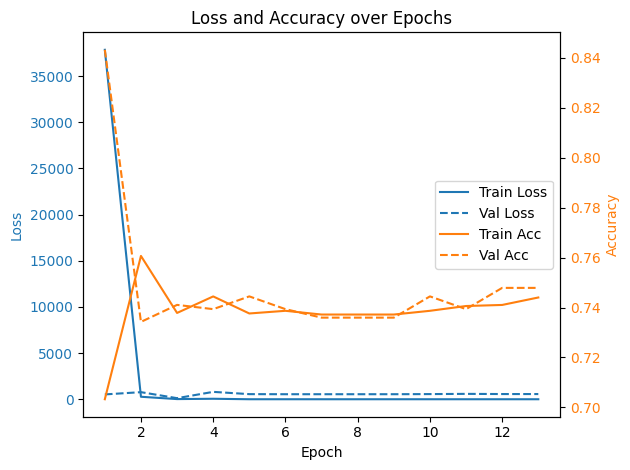

Test accuracy: 0.5433
Detected 2 classes: [0 1]


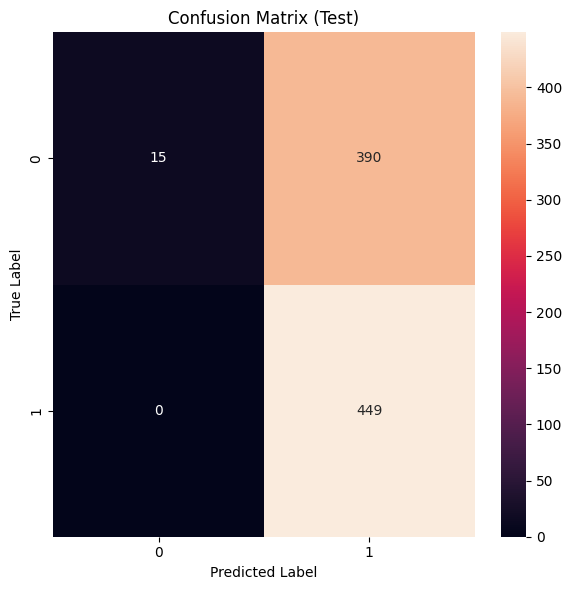

In [39]:
display_results("models/baseline.pth")

#### With Augmentations

In [37]:
train("augmentations")

Epoch 01 | train: loss=23168.5932, acc=0.7605 | val: loss=108.7930, acc=0.7617 | time: 4.03s
  -> New best val_loss 108.7930 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=117.5816, acc=0.7651 | val: loss=415.3611, acc=0.7126 | time: 3.03s
Epoch 03 | train: loss=103.5503, acc=0.7564 | val: loss=44.3180, acc=0.7593 | time: 3.60s
  -> New best val_loss 44.3180 at epoch 3. Saved to best.pt.
Epoch 04 | train: loss=11.6691, acc=0.7774 | val: loss=4.9744, acc=0.7815 | time: 3.27s
  -> New best val_loss 4.9744 at epoch 4. Saved to best.pt.
Epoch 05 | train: loss=3.4297, acc=0.7695 | val: loss=2.9039, acc=0.7442 | time: 3.09s
  -> New best val_loss 2.9039 at epoch 5. Saved to best.pt.
Epoch 06 | train: loss=2.6335, acc=0.7564 | val: loss=5.1379, acc=0.7640 | time: 3.03s
Epoch 07 | train: loss=4.3214, acc=0.7431 | val: loss=4.1650, acc=0.7336 | time: 3.26s
Epoch 08 | train: loss=1.4628, acc=0.7278 | val: loss=2.4825, acc=0.7278 | time: 3.12s
  -> New best val_loss 2.4825 at epoch 8. Saved

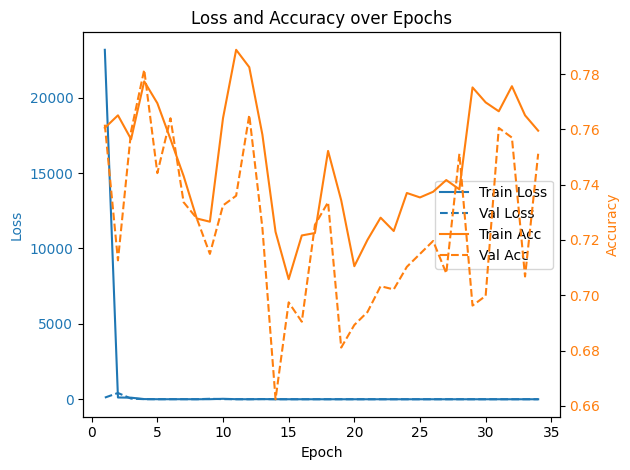

Test accuracy: 0.7389
Detected 2 classes: [0 1]


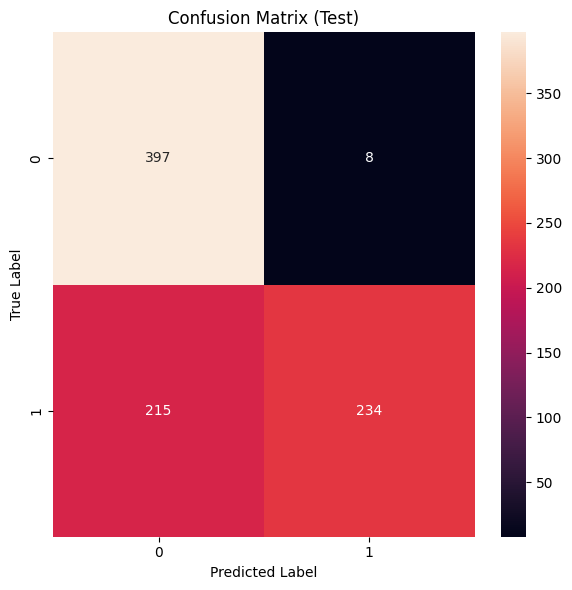

In [38]:
display_results("models/augmentations.pth")

#### Trying SGD instead of adam

In [47]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
train("lower_learning_rate")

Epoch 01 | train: loss=1.6499, acc=0.5421 | val: loss=143.6528, acc=0.5397 | time: 1.86s
  -> New best val_loss 143.6528 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=1.0275, acc=0.5518 | val: loss=149.9092, acc=0.5397 | time: 1.71s
Epoch 03 | train: loss=0.7385, acc=0.5582 | val: loss=144.7645, acc=0.5444 | time: 1.77s
Epoch 04 | train: loss=0.6888, acc=0.5549 | val: loss=139.9617, acc=0.5397 | time: 1.83s
  -> New best val_loss 139.9617 at epoch 4. Saved to best.pt.
Epoch 05 | train: loss=0.7476, acc=0.5582 | val: loss=148.1692, acc=0.5444 | time: 1.70s
Epoch 06 | train: loss=0.7196, acc=0.5560 | val: loss=143.4281, acc=0.5444 | time: 1.88s
Epoch 07 | train: loss=0.6758, acc=0.5516 | val: loss=139.0158, acc=0.5409 | time: 1.69s
  -> New best val_loss 139.0158 at epoch 7. Saved to best.pt.
Epoch 08 | train: loss=0.6531, acc=0.5582 | val: loss=151.2301, acc=0.5397 | time: 1.92s
Epoch 09 | train: loss=0.7474, acc=0.5582 | val: loss=146.6153, acc=0.5397 | time: 1.70s
Epoch 10 | tr

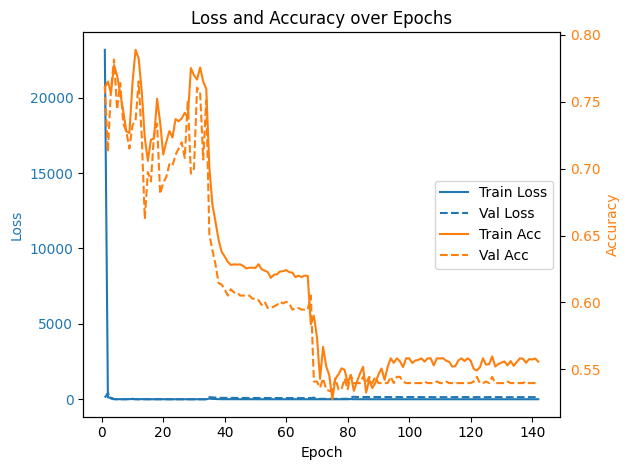

Test accuracy: 0.5304
Detected 2 classes: [0 1]


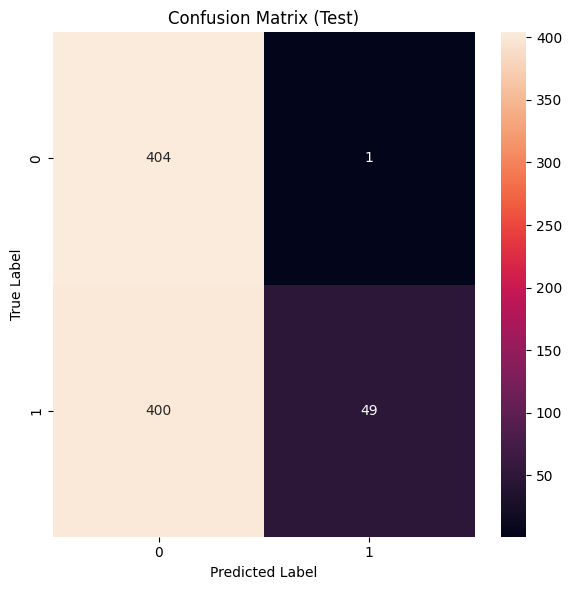

In [48]:
display_results("models/lower_learning_rate.pth")

#### Extra layer

In [53]:
optimizer = optim.Adam(model.parameters(), lr=0.1)
train("extra_layer")

Epoch 01 | train: loss=1470717.8152, acc=0.6802 | val: loss=3765.5292, acc=0.8493 | time: 4.70s
  -> New best val_loss 3765.5292 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=6818.8245, acc=0.7845 | val: loss=781.6447, acc=0.8446 | time: 4.15s
  -> New best val_loss 781.6447 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=1339.4315, acc=0.8322 | val: loss=649.9018, acc=0.8914 | time: 4.13s
  -> New best val_loss 649.9018 at epoch 3. Saved to best.pt.
Epoch 04 | train: loss=196.4488, acc=0.8328 | val: loss=329.0342, acc=0.6110 | time: 4.32s
  -> New best val_loss 329.0342 at epoch 4. Saved to best.pt.
Epoch 05 | train: loss=69.5836, acc=0.8584 | val: loss=26.8744, acc=0.8551 | time: 4.21s
  -> New best val_loss 26.8744 at epoch 5. Saved to best.pt.
Epoch 06 | train: loss=4.9229, acc=0.6833 | val: loss=0.5371, acc=0.6414 | time: 4.08s
  -> New best val_loss 0.5371 at epoch 6. Saved to best.pt.
Epoch 07 | train: loss=0.8494, acc=0.5998 | val: loss=0.5483, acc=0.6343 | time: 4.

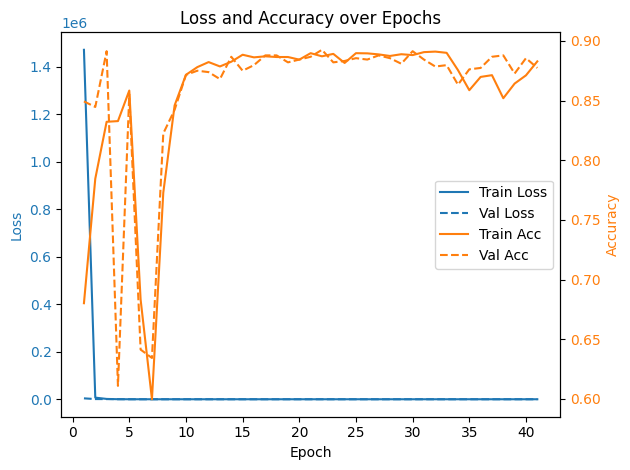

Test accuracy: 0.9028
Detected 2 classes: [0 1]


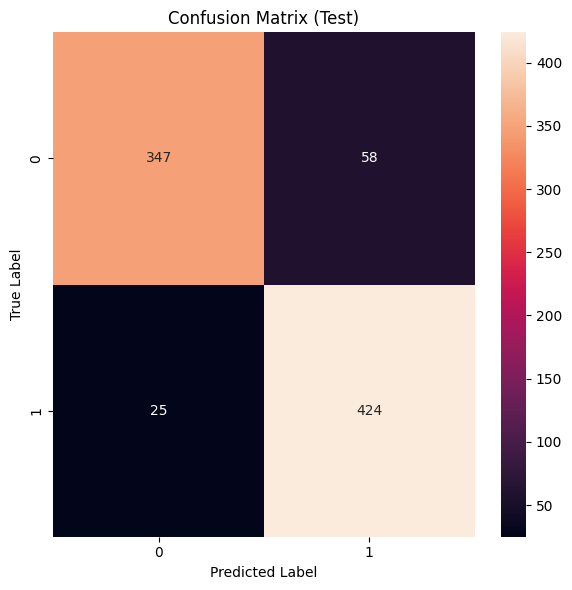

In [54]:
display_results("models/extra_layer.pth")

#### Two more layers

In [70]:
train("two_more_layers")

Epoch 01 | train: loss=10640272.7744, acc=0.5663 | val: loss=2893.5110, acc=0.5421 | time: 4.65s
  -> New best val_loss 2893.5110 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=623134.2437, acc=0.4978 | val: loss=0.6932, acc=0.4918 | time: 4.57s
  -> New best val_loss 0.6932 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=0.6993, acc=0.4901 | val: loss=0.6934, acc=0.5082 | time: 4.56s
Epoch 04 | train: loss=0.7040, acc=0.4941 | val: loss=0.6958, acc=0.5082 | time: 3.75s
Epoch 05 | train: loss=0.7068, acc=0.5003 | val: loss=0.6969, acc=0.5082 | time: 3.55s
Epoch 06 | train: loss=0.7028, acc=0.5009 | val: loss=0.6935, acc=0.5082 | time: 3.70s
Epoch 07 | train: loss=0.6972, acc=0.5061 | val: loss=0.6992, acc=0.5082 | time: 3.58s
Epoch 08 | train: loss=0.6999, acc=0.5140 | val: loss=0.7091, acc=0.5082 | time: 3.62s
Epoch 09 | train: loss=0.7002, acc=0.5018 | val: loss=0.6969, acc=0.4918 | time: 3.60s
Epoch 10 | train: loss=0.6981, acc=0.5020 | val: loss=0.6948, acc=0.4918 | time

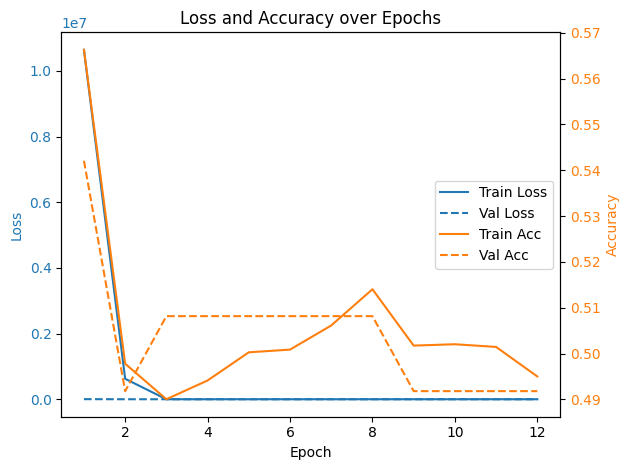

Test accuracy: 0.5105
Detected 2 classes: [0 1]


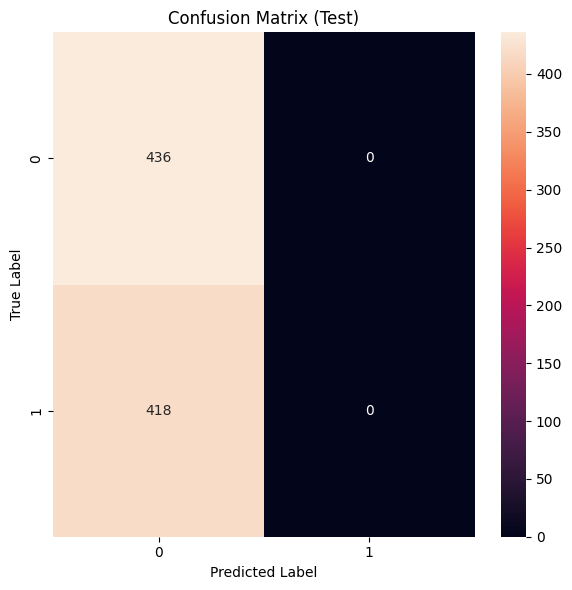

In [71]:
display_results("models/two_more_layers.pth")

# Convolutional Neural Network